In [1]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau # CosineAnnealingWarmRestarts
from torch.optim.sgd import SGD
from torch.optim.adam import Adam

from warmup_scheduler import GradualWarmupScheduler
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# from cosine_annearing_with_warmup import CosineAnnealingWarmUpRestarts

In [3]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = self.last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None and self.last_epoch < 0:
            epoch = 0
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            

            
            
class CosineAnnealingWarmRestarts(_LRScheduler):

    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min

        super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch)

        self.T_cur = self.last_epoch

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]
    def step(self, epoch=None):
        if epoch is None and self.last_epoch < 0:
            epoch = 0

        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
        self.last_epoch = math.floor(epoch)

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False
                return self

        with _enable_get_lr_call(self):
            for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
                param_group['lr'] = lr

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

In [4]:
# ??CosineAnnealingLR

In [17]:
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
lr = 1e-2
# optim = SGD(model, lr= 0.0001)
epochs = 60
warmup_factor = 1
warmup_epoch = 5
optim = Adam(model, lr=lr / warmup_factor)
# scheduler_warmup is chained with schduler_steplr
# scheduler_steplr = StepLR(optim, step_size=10, gamma=0.1)
# scheduler_steplr = CosineAnnealingLR(optim, T_max=50)
# scheduler_warmup = CosineAnnealingWarmRestarts(optim, T_0=40, T_mult=1)
# scheduler_warmup = GradualWarmupScheduler(optim, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)
scheduler_warmup = CosineAnnealingWarmUpRestarts(optim, T_0=40, T_mult=1, eta_max=0.0007, T_up=5, gamma=0.5, last_epoch=-1)



# scheduler_cosine = CosineAnnealingLR(optim, epochs - warmup_epoch)
# scheduler_cosine = StepLR(optim, step_size=3, gamma=0.8,)
# scheduler_warmup = GradualWarmupScheduler(
#     optim, multiplier=warmup_factor,
#     total_epoch=warmup_epoch,
#     after_scheduler=scheduler_cosine
# )

# this zero gradient update is needed to avoid a warning message, issue #8.
# optim.zero_grad()
# optim.step()

lr_steps = []
for epoch in range(1, epochs):
    scheduler_warmup.step(epoch)
    lr_steps.append(optim.param_groups[0]['lr'])

    optim.step()    # backward pass (update network)

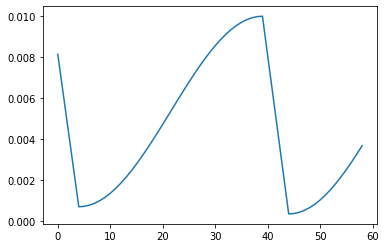

In [18]:
plt.plot(lr_steps)

In [68]:
lr_steps

[1.4000000000000001e-06,
 2.8000000000000003e-06,
 4.2e-06,
 5.600000000000001e-06,
 7e-06,
 7e-06,
 7e-06,
 5.600000000000001e-06,
 5.600000000000001e-06,
 5.600000000000001e-06,
 4.480000000000001e-06,
 4.480000000000001e-06,
 4.480000000000001e-06,
 3.5840000000000008e-06,
 3.5840000000000008e-06,
 3.5840000000000008e-06,
 2.8672000000000007e-06,
 2.8672000000000007e-06,
 2.8672000000000007e-06,
 2.2937600000000005e-06,
 2.2937600000000005e-06,
 2.2937600000000005e-06,
 1.8350080000000007e-06,
 1.8350080000000007e-06,
 1.8350080000000007e-06,
 1.4680064000000005e-06,
 1.4680064000000005e-06,
 1.4680064000000005e-06,
 1.1744051200000005e-06]

In [10]:
lr_steps

[1.4000000000000001e-06,
 2.8000000000000003e-06,
 4.2e-06,
 5.600000000000001e-06,
 7e-06,
 7e-06,
 6.890041063950209e-06,
 6.754217700608879e-06,
 6.567073380153522e-06,
 6.331559480312316e-06,
 6.05139019597494e-06,
 5.730983964120414e-06,
 5.375393782426488e-06,
 4.9902275204777545e-06,
 4.581559480312316e-06,
 4.1558346010500365e-06,
 3.719766818352597e-06,
 3.2802331816474033e-06,
 2.844165398949964e-06,
 2.418440519687685e-06,
 2.009772479522246e-06,
 1.6246062175735108e-06,
 1.2690160358795858e-06,
 9.486098040250603e-07,
 6.684405196876843e-07,
 4.3292661984647747e-07,
 2.4578229939112027e-07,
 1.0995893604979162e-07,
 2.759854539932782e-08]

In [7]:
lr_steps

[1.4000000000000001e-06,
 2.8000000000000003e-06,
 4.2e-06,
 5.600000000000001e-06,
 7e-06,
 7e-06,
 6.331559480312316e-06,
 5.557248383023656e-06,
 4.581559480312316e-06,
 3.5e-06,
 2.418440519687684e-06,
 1.4427516169763444e-06,
 6.684405196876843e-07,
 1.7130219296696264e-07]

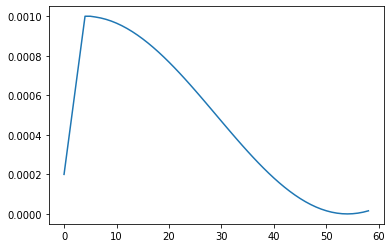

In [24]:
plt.plot(lr_steps)

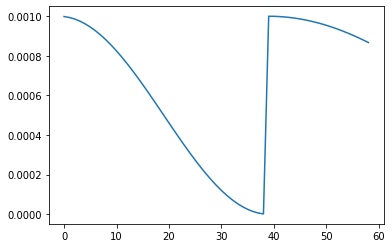

In [34]:
plt.plot(lr_steps)

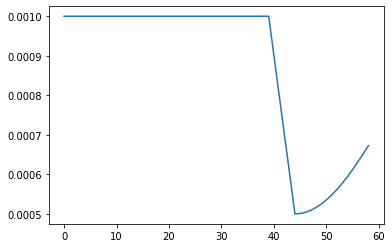

In [23]:
plt.plot(lr_steps)

In [20]:
lr_steps

[0.02008,
 0.040060000000000005,
 0.06004000000000001,
 0.08002000000000001,
 0.1,
 0.0997989159850622,
 0.09919728295050156,
 0.09819994489175787,
 0.09681493178845488,
 0.09505339495172584,
 0.09292951724041322,
 0.09046039886902862,
 0.08766591972688038,
 0.0845685793168939,
 0.08119331560284375,
 0.07756730422353253,
 0.07371973969052628,
 0.0696816003311135,
 0.06548539886902863,
 0.06116492065111791,
 0.05675495162759189,
 0.05229099827600823,
 0.04780900172399179,
 0.043345048372408115,
 0.0389350793488821,
 0.03461460113097138,
 0.030418399668886528,
 0.026380260309473717,
 0.022532695776467482,
 0.018906684397156263,
 0.01553142068310611,
 0.012434080273119638,
 0.00963960113097138,
 0.007170482759586789,
 0.005046605048274169,
 0.0032850682115451264,
 0.0019000551082421306,
 0.0009027170494984481,
 0.00030108401493780855,
 0.0001,
 0.010079999999999999,
 0.020059999999999998,
 0.03004,
 0.04002,
 0.05,
 0.049899558635181224,
 0.049599043235535815,
 0.04910087337436154,
 0.048